In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import datetime

In [2]:
conn=sqlite3.connect('db.db')
data=pd.read_sql("SELECT * FROM training_5month",conn)
data=data.sort_values('date')

In [3]:
df=data[['date','cost']]

In [4]:
df=df.groupby('date').agg({'cost': 'sum'})

In [5]:
df['date']=data['date'].unique()

In [6]:
start_time =df["date"][0]

In [7]:
def transform(string):
    try:
        if string[:4]=='2023':
            string=datetime.datetime.strptime(string, '%Y-%m-%d')
            string=str(datetime.datetime.date(string) - datetime.timedelta(days=33) )
        a=datetime.datetime.strptime(string, '%Y-%m-%d')-datetime.datetime.strptime(start_time, '%Y-%m-%d')
        chislo=''
        for i in str(a):
            if i==' ':
                break
            else:
                chislo += i
        return int(chislo)
    except ValueError:
        return 0
        

In [8]:
df['day']= df['date'].apply(transform)
df["window_rolling_sum"]= df["cost"].cumsum()

In [9]:
df.day[0]=0

<ipython-input-9-481bcb368008>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.day[0]=0


In [10]:
d=df[df.cost>2000]
df=df[df.cost<=2000]

In [11]:
df['day']= df['date'].apply(transform)
df["window_rolling_sum"]= df["cost"].cumsum()
#df.day.max

In [12]:
X,y=df.day,df.window_rolling_sum
X_train, X_test, y_train, y_test = X[X%4!=0],X[X%4==0],y[X%4!=0],y[X%4==0]

In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression
X_train=np.array(X_train).reshape(-1,1)
y_train=np.array(y_train)
X_test=np.array(X_test).reshape(-1,1)
y_test=np.array(y_test)

model = LinearRegression(normalize=False,fit_intercept=False)
model.fit(X_train, y_train)
print('Accuracy: ',model.score(X_test, y_test))
y_pred=model.predict(X_test)

Accuracy:  0.9904029030345501


In [14]:
df.groupby(df.day//30).agg({"cost":"mean"})

,cost
day,
0,493.672273
1,600.718000
2,507.831364
3,544.312500
4,1422.500000


In [15]:
q=pd.DataFrame(np.hstack([X_test, y_pred.reshape(-1,1)]))
e=pd.DataFrame(np.hstack([X_test, y_test.reshape(-1,1)]))
q.columns=['day','summ']
e.columns=['day','summ']
q=q[1:-2]
e=e[1:-2]

In [16]:
q['date']=list(df['date'][3::4])
e.columns=['day','summ']
e['date']=list(df['date'][3::4])
k=pd.DataFrame(['октябрь' if i==0 else 'ноябрь' if i ==1 else 'декабрь' if i==2 else 'февраль' if i==3 else 'март' for i in list(e.day//30)])
k.columns=['class']
e=e.join(k)
k

,class
0,октябрь
1,октябрь
2,октябрь
3,октябрь
4,октябрь
5,октябрь
6,ноябрь
7,ноябрь
8,ноябрь
9,ноябрь


In [17]:
e["class"][20]='март'

<ipython-input-17-ecfc9b8f4bff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e["class"][20]='март'


In [18]:
q

,day,summ,date
1,4.0,1546.877192,2022-10-05
2,12.0,4640.631575,2022-10-11
3,16.0,6187.508767,2022-10-17
4,20.0,7734.385959,2022-10-21
5,24.0,9281.263151,2022-10-27
6,28.0,10828.140343,2022-11-02
7,32.0,12375.017534,2022-11-08
8,36.0,13921.894726,2022-11-12
9,40.0,15468.771918,2022-11-16
10,44.0,17015.649110,2022-11-22


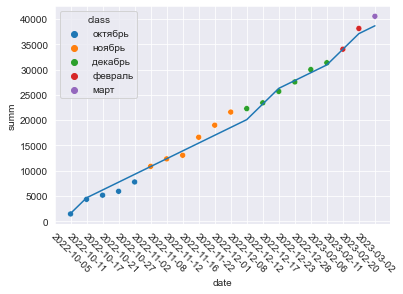

In [19]:
import seaborn as sns
sns.set_style("darkgrid")
sns.lineplot(data=q,x='date',y='summ')
sns.scatterplot(data=e,x='date',y='summ',hue='class')
plt.xticks(rotation=-45)
plt.savefig('General_linear_regression.png')

In [20]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('mse: %.3f, mae: %.3f' % (mse, mae))

mse: 1692738.925, mae: 989.932


In [21]:
temp=list(model.predict([[30],[90],[365]]))
print(f'За месяц вы обычно тратите {round(temp[0])} рублей, за сезон {round(temp[1])} рублей, за год {round(temp[2])} рублей')


За месяц вы обычно тратите 11602 рублей, за сезон 34805 рублей, за год 141153 рублей


In [22]:
 len(d)

7

In [23]:
d=d.drop('day',axis=1)
d.index=range(0,len(d))
d=d.drop('window_rolling_sum',axis=1)

In [24]:
d=d[['date','cost']]
d#.plot()
#plt.savefig('Unusual_purchases.png')

,date,cost
0,2022-10-14,2721.32
1,2022-11-20,2030.00
2,2022-12-14,2080.00
3,2022-12-31,5183.00
4,2023-02-09,3325.00
5,2023-02-14,2004.00
6,2023-02-21,2361.00


In [25]:
vrem=data.groupby('date',as_index=False).agg({'cost': 'sum'})

In [26]:
temp=float(vrem.mean()+1.96*vrem.std()/np.sqrt(len(vrem)))
tem=float(vrem.mean()-1.96*vrem.std()/np.sqrt(len(vrem)))
print(f'Ваша дневная норма трат: от {round(tem)} до {round(temp)} рублей\n\
        Количество дней превышения нормы: {len(vrem[vrem["cost"]>temp])}\n\
        В эти дни вы позволяете себе превышать норму в среднем в {round(vrem[vrem["cost"]>temp].mean()[0]/temp,1)} раза')

Ваша дневная норма трат: от 571 до 896 рублей
        Количество дней превышения нормы: 20
        В эти дни вы позволяете себе превышать норму в среднем в 2.0 раза


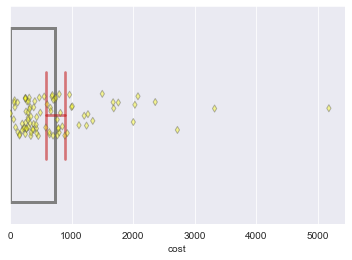

In [27]:
sns.barplot(x=vrem['cost'],palette='hls', linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),errcolor=(0.75,0,0,0.5),capsize=.4)
sns.stripplot(x=vrem['cost'],marker="d",linewidth=1, alpha=0.4, color="yellow") # херовый график, заменить на барплот 
plt.savefig('boxplot.png')

График распределения трат

In [28]:
depends=data.groupby(data.place,as_index=False).agg({'cost':['sum','mean'],'date':'max'})
depends =depends.sort_values(( 'cost',  'sum'),ascending=False)[:12]
depends.columns=['place','sum','avg','last_visit']
depends.index=range(0,len(depends))
depends
###########################

,place,sum,avg,last_visit
0,Яндекс.Еда,8920.00,991.111111,2022-12-31
1,Yandex Bank,7807.00,1951.750000,2023-02-21
2,Пятёрочка,4854.43,404.535833,2022-12-30
3,dodopizza.ru G SMOLENSK RUS,3898.00,556.857143,2022-12-10
4,KFC,3605.00,300.416667,2022-12-06
5,Яндекс.Лавка,3413.89,568.981667,2022-11-12
6,Vkusno - i tochka,3411.00,189.500000,2022-12-31
7,DNS,3299.00,3299.000000,2022-12-31
8,BK BURGER RUS GOROD MOSKVA RUS,3134.76,241.135385,2022-12-28
9,dodopizza G SMOLENSK RUS,2741.00,913.666667,2022-11-18


Таблица топ расходов за все время. 12 пунктов

In [29]:
data_sum = pd.concat([q["summ"], e["summ"]], axis= 1 )
data_sum.corr()

,summ,summ
summ,1.000000,0.995192
summ,0.995192,1.000000


Строим модель на основе 14 дней

In [30]:
data2=pd.read_sql("SELECT * FROM train_14days",conn)
data2=data2.sort_values('date')
data2
####################

,train_id,card,timing,cost,place,balance,date
9,88,ECMC8041,13:03:00,8,UNIVERSERVIS,3307.93,2023-02-20
7,91,ECMC8041,11:59:00,244,vkusno - I tochka_11027,946.93,2023-02-21
8,89,ECMC8041,11:51:00,2117,Yandex Bank,1190.93,2023-02-21
5,95,ECMC8041,19:46:00,71,Yandex.Lavka,527.93,2023-02-22
6,94,ECMC8041,14:18:00,248,QSR 11027,598.93,2023-02-22
4,98,ECMC8041,19:37:00,301,Yandex.Lavka,111.93,2023-02-24
3,114,ECMC8041,12:08:00,155,KIOSK 1,16095.01,2023-03-01
2,118,ECMC8041,14:48:00,269,vkusno - I tochka_11027,13426.01,2023-03-02
1,121,ECMC8041,14:10:00,1345,VMK,11981.01,2023-03-03
0,126,ECMC8041,14:16:00,1500,MEDITSINSKIY DOM,8811.01,2023-03-05


In [31]:
df2=data2[['date','cost']]
start_time= df2['date'].min()

In [32]:
def transform2(string):
    try:
        a=datetime.datetime.strptime(string, '%Y-%m-%d')-datetime.datetime.strptime(start_time, '%Y-%m-%d')
        chislo=''
        for i in str(a):
            if i==' ':
                break
            else:
                chislo += i
        return int(chislo)
    except ValueError:
        return 0

In [33]:
df2=df2.groupby('date',as_index=False).agg({'cost': 'sum'})
df2["window_rolling_sum"]= df2["cost"].cumsum()
df2['day']= df2['date'].apply(transform2)
df2["day"][0]=1
df2
#########################

<ipython-input-33-88569ed7a5d2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["day"][0]=1


,date,cost,window_rolling_sum,day
0,2023-02-20,8,8,1
1,2023-02-21,2361,2369,1
2,2023-02-22,319,2688,2
3,2023-02-24,301,2989,4
4,2023-03-01,155,3144,9
5,2023-03-02,269,3413,10
6,2023-03-03,1345,4758,11
7,2023-03-05,1500,6258,13


In [34]:
df2=df2[df2.cost<=3000]

In [35]:
model2 = LinearRegression(fit_intercept=False)
X,y = df2.day,df2.window_rolling_sum
X=np.array(X).reshape(-1,1)
model2.fit(X,y)

LinearRegression(fit_intercept=False)

In [36]:
model2.coef_

array([437.78296146])

In [37]:
y_pred=model2.predict(np.array(range(0,28)).reshape(-1,1))

In [38]:
y_pred

array([    0.        ,   437.78296146,   875.56592292,  1313.34888438,
        1751.13184584,  2188.9148073 ,  2626.69776876,  3064.48073022,
        3502.26369168,  3940.04665314,  4377.8296146 ,  4815.61257606,
        5253.39553753,  5691.17849899,  6128.96146045,  6566.74442191,
        7004.52738337,  7442.31034483,  7880.09330629,  8317.87626775,
        8755.65922921,  9193.44219067,  9631.22515213, 10069.00811359,
       10506.79107505, 10944.57403651, 11382.35699797, 11820.13995943])

In [39]:
def backtransform(start):
    spis=[]
    for i in range(0,28):
        spis.append(str(datetime.datetime.strptime(start, '%Y-%m-%d')+datetime.timedelta(days=i))[:10])
    return spis

In [40]:
dftime=backtransform(start_time)######################не используется

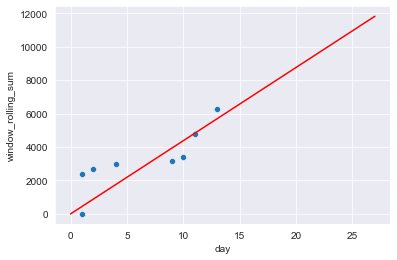

In [41]:
sns.set_style("darkgrid")
sns.lineplot(x=range(0,28),y=y_pred,color='red')
sns.scatterplot(data=df2,x='day',y='window_rolling_sum')
plt.savefig('Selecting_regression.png')

Статистические тесты

In [42]:
def transform2(string):
        a=datetime.datetime.strptime(string, '%Y-%m-%d')
        return int(str(a)[5:7])

In [43]:
vrem=data.groupby('date',as_index=False).agg({'cost': 'sum'})

In [44]:
vrem['month']=vrem["date"].apply(transform2)

In [ ]:
n_1=int(input('Введите порядковый номер первого месяца:  '))
n_2=int(input('Введите порядковый номер второго месяца:  '))
list_1= vrem[vrem['month']==n_1]
list_2= vrem[vrem['month']==n_2]
list_1

In [ ]:
abc1=np.mean(list_1.cost)
abc2=np.mean(list_2.cost)
abc1

In [ ]:
import scipy.stats as stats
a_value= round(stats.ttest_ind(a=list_1.cost, b=list_2.cost, equal_var=True)[1]*100,3)
if a_value<10:
    print(f'Среднее значение трат намного выше в {n_1 if abc1>abc2 else n_2} месяце и это не случайность. Мы уверены что не ошиблись с вероятностью {100-a_value}%')
else:
    print('Данные двух месяцев слишком похожи, чтобы сделать какие-то выводы насчет ваших трат. В любом случае, старайтесь тратить меньше!')

In [ ]:
data2

In [ ]:
def check_time_part(time):
    a = int(time[:2])+3
    if a>=19 and a<24: 
        return 'evening'
    elif a >= 13 and a<19: 
        return'day'
    elif a>=7 and a<13:
        return 'morning'
    else: 
        return 'night'

In [ ]:
data2['time_of_day']= data2["timing"].apply(check_time_part)

In [ ]:
mean_amount = data2.groupby('time_of_day')['cost'].mean()
time_amount =  data2[['time_of_day','timing','cost']].sort_values('timing')
sum_amount = data2.groupby('time_of_day')['cost'].sum()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots()
mean_amount.plot(kind='bar').set_ylabel('Mean expenses per day')
plt.xticks(rotation=0)
plt.savefig('barplot.png')
time_amount.plot(x='time_of_day', y='timing', kind ='scatter',sizes =time_amount['cost']/10) # строим 2-ый  
plt.savefig('scatterplot.png')

In [ ]:
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d} Руб.)"

times= ['morning','day','evening']
fig, ax = plt.subplots(figsize=(15, 7.5), subplot_kw=dict(aspect="equal"))
wedges, texts , autotexts= ax.pie(sum_amount,autopct=lambda pct: func(pct, sum_amount))
plt.setp(autotexts, size=8, weight="bold")
ax.legend(wedges, times,
          title="Time of day",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=16, weight="bold")
plt.savefig('pieplot.png')
plt.show()

In [35]:
    """Converts data into month and return month"""
    def transform_month(string):
        a=datetime.datetime.strptime(string, '%Y-%m-%d')
        return int(str(a)[5:7])

In [36]:
def prepare_data_for_ttest_month( spis):
        temp = data.groupby(data.place,
                                    as_index=False).agg({'cost': ['sum',
                                                        'mean'], 'date': 'max'})
        temp.columns=['place','cost','mean','maxi']
        temp['month'] = temp.maxi.apply(transform_month)
        m_1, m_2 = spis.split()
        m_1, m_2 = int(m_1), int(m_2)
        list_1 = temp[temp['month'] == m_1]
        list_2 = temp[temp['month'] == m_2]
        return list_1, list_2, m_1, m_2

In [37]:
list1, list2, m1, m2 = prepare_data_for_ttest_month('1 10')

In [26]:
temp

place     cost                     date
                                           sum         mean         max
0                                      2076.00   415.200000  2023-03-10
1      BK BURGER RUS GOROD MOSKVA RUS  3134.76   241.135385  2022-12-28
2         BURGER KING 0438 MOSCOW RUS   129.99   129.990000  2022-11-07
3   DELIVERY CLUB YA GOROD MOSKVA RUS  1595.98   797.990000  2022-12-17
4                                 DNS  3299.00  3299.000000  2022-12-31
5                  DONUTTO MOSKVA RUS   150.00   150.000000  2022-11-10
6                       Delivery Club   639.00   639.000000  2022-11-17
7            FIXPRICE 8065 MOSCOW RUS   812.20   135.366667  2022-12-30
8                                 KFC  4187.00   322.076923  2023-03-07
9                             KIOSK 1   155.00   155.000000  2023-03-01
10           KIOSK 1 GOROD MOSKVA RUS   695.00   173.750000  2022-11-08
11          KORPUS V GOROD MOSKVA RUS   485.00   121.250000  2022-12-06
12              KULLKLEVER MOSCOW RUS   158.00   158.000000  2022-11-15
13                      MARKET.YANDEX   116.00   116.000000  2023-02-04
14                   MEDITSINSKIY DOM  1500.00  1500.000000  2023-03-05
15                      MGUPI BUFET 1    90.00    90.000000  2023-02-09
16     MGUPI BUFET 1 GOROD MOSKVA RUS   515.00    73.571429  2022-12-28
17     MGUPI BUFET 2 GOROD MOSKVA RUS   260.00    86.666667  2022-10-24
18   MGUPI STOLOVAYA GOROD MOSKVA RUS    35.00    35.000000  2022-11-14
19        MegaFon. TINKOFF MOSCOW RUS   660.00   660.000000  2022-11-10
20                       Moskva Metro   470.00   470.000000  2023-02-13
21                   One Price Coffee   560.00   186.666667  2022-11-09
22                        PEREKRESTOK   646.76   215.586667  2023-02-10
23           PIZZASUSHIWOK MOSCOW RUS   339.00   339.000000  2022-12-01
24                        PYATEROCHKA  1620.39   405.097500  2023-02-15
25                          QSR 11027   443.00   221.500000  2023-02-22
26                          SPAR N312   259.68   259.680000  2023-02-16
27                             SUBWAY   350.00   350.000000  2022-10-24
28                       UNIVERSERVIS    38.00    19.000000  2023-02-20
29         VKUSVILL 1549 6 MOSCOW RUS    25.00    25.000000  2022-12-22
30                                VMK  1345.00  1345.000000  2023-03-03
31                  Vkusno - i tochka  3411.00   189.500000  2022-12-31
32                        Yandex Bank  7807.00  1951.750000  2023-02-21
33                       Yandex.Lavka   496.00   165.333333  2023-02-24
34                          dodopizza   440.00   440.000000  2023-02-07
35           dodopizza G SMOLENSK RUS  2741.00   913.666667  2022-11-18
36        dodopizza.ru G SMOLENSK RUS  3898.00   556.857143  2022-12-10
37                              hh.ru   199.00   199.000000  2022-11-23
38            vkusno - I tochka_11027  1769.00   221.125000  2023-03-09
39                    Красное и белое    90.68    90.680000  2022-10-20
40                            МегаФон   550.00   550.000000  2022-10-11
41                       Метро Москвы   992.00   330.666667  2022-12-05
42                 Оплата или перевод  1070.00   356.666667  2023-03-10
43                          Пятёрочка  4854.43   404.535833  2022-12-30
44                         Яндекс.Еда  8920.00   991.111111  2022-12-31
45                       Яндекс.Лавка  3413.89   568.981667  2022-11-12